# Alexnet

In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

# 1. load data

In [36]:
data_dir = 'data/hymenoptera_data'
data_means = [0.490, 0.449, 0.411]
data_stddevs = [0.231, 0.221, 0.230]
data_transformers = {
    'train': torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                             torchvision.transforms.RandomHorizontalFlip(),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(data_means, data_stddevs)]),
    'val': torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                             torchvision.transforms.CenterCrop(224),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(data_means, data_stddevs)])
}
img_data = {type: torchvision.datasets.ImageFolder(os.path.join(data_dir, type), data_transformers[type])
            for type in ['train', 'val']} 
data_loaders = {type: torch.utils.data.DataLoader(img_data[type], batch_size=8, shuffle=True, num_workers=0)
               for type in ['train', 'val']}
dataset_sizes = {type: len(img_data[type]) for type in ['train', 'val']}
classes = img_data['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## visualize sample data

In [3]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1,2,0)) # the channel should be the last to broadcast in std*img+avg.
#     print(img.shape)
    avg = np.array(data_means)
    stddev = np.array(data_stddevs)
    img = stddev * img + avg
    img = np.clip(img,0,1) # clip to the valid range to show images. 
    plt.imshow(img)
    if text is not None:
        plt.title(text)

loaded image shape: (B, C, H, W) = torch.Size([8, 3, 224, 224])
grid image shape = torch.Size([3, 228, 1810])


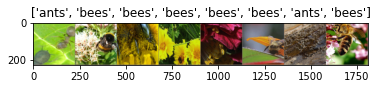

In [4]:
imgs, cls = next(iter(data_loaders['train']))
print(f'loaded image shape: (B, C, H, W) = {imgs.shape}')
grid = torchvision.utils.make_grid(imgs)
print(f'grid image shape = {grid.shape}') # padding=2, so width = 224*8 + 2*9 = 1810
imageshow(grid, text=[classes[c] for c in cls])

# 2. Training

In [5]:
def finetune_model(pretrained_model, loss_func, optimizer, epochs=10):
    start = time.time()
    pretrained_model.to(device)
    model_weights = copy.deepcopy(pretrained_model.state_dict())
    best_accuracy = 0.0
    
    for e in range(epochs):
        print(f'Epoch = {e} in {epochs - 1}')
        print('=' * 20)
        
        train_1epoch(pretrained_model, loss_func, optimizer)
        validate_1epoch(pretrained_model, loss_func, optimizer, best_accuracy)
        
    time_passed = time.time() - start
    print(f'Training finished in {time_passed // 60} mins {time_passed % 60} secs')
    print(f'Best validation accuracy = {best_accuracy}')
    
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model

In [6]:
def train_1epoch(pretrained_model, loss_func, optimizer):
        pretrained_model.train()
        loss = 0.0
        successes = 0
        
        for imgs, tgts in data_loaders['train']:
            imgs = imgs.to(device)
            tgts = tgts.to(device) || target: {classes[int(tgts[j])]}
            optimizer.zero_grad()
            
            torch.set_grad_enabled(True)
            outputs = pretrained_model(imgs)
            _, predictions = torch.max(outputs, 1) # discard max value, keep max indices
            loss_curr = loss_func(outputs, tgts)

            loss_curr.backward()
            optimizer.step()
            
            loss += loss_curr.item() * imgs.size(0) # item() extracts the loss’s value as a Python float. it is multiplied by batch size(=imgs.size(0))
            successes += torch.sum(predictions == tgts.data)
            
        loss /= dataset_sizes['train']
        accuracy = successes.double() / dataset_sizes['train']
        
        print(f'train loss in this epoch = {loss}')
        print(f'train accuracy in this epoch = {accuracy}')

In [7]:
def validate_1epoch(pretrained_model, loss_func, optimizer, best_accuracy):
        pretrained_model.eval()
        loss = 0.0
        successes = 0
        
        for imgs, tgts in data_loaders['val']:
            imgs = imgs.to(device)
            tgts = tgts.to(device)
            optimizer.zero_grad()
            
            torch.set_grad_enabled(False)
            outputs = pretrained_model(imgs)
            _, predictions = torch.max(outputs, 1) # discard max value, keep max indices
            loss_curr = loss_func(outputs, tgts)
            
            loss += loss_curr.item() * imgs.size(0) # item() extracts the loss’s value as a Python float. it is multiplied by batch size
            successes += torch.sum(predictions == tgts.data)
            
        loss /= dataset_sizes['val']
        accuracy = successes.double() / dataset_sizes['val']
        
        print(f'validation loss in this epoch = {loss}')
        print(f'validation accuracy in this epoch = {accuracy}')
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model_weights = copy.deepcopy(pretrained_model.state_dict())

In [8]:
alexnet = torchvision.models.alexnet(pretrained = True)
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.0001)

In [9]:
print(alexnet.features)
print(alexnet.classifier)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True

In [10]:
# change the last layer to 2 classes
alexnet.classifier[6] = torch.nn.Linear(4096, len(classes))

In [102]:
# train
alexnet = finetune_model(alexnet, torch.nn.CrossEntropyLoss(),
                        optimizer, epochs=10)

Epoch = 0 in 9
train loss in this epoch = 0.9286651044595436
train accuracy in this epoch = 0.4098360655737705
validation loss in this epoch = 1.0155118571387396
validation accuracy in this epoch = 0.30718954248366015
Epoch = 1 in 9
train loss in this epoch = 0.9172931518711027
train accuracy in this epoch = 0.42213114754098363
validation loss in this epoch = 0.9726228885401308
validation accuracy in this epoch = 0.33986928104575165
Epoch = 2 in 9
train loss in this epoch = 0.8769646199023138
train accuracy in this epoch = 0.43032786885245905
validation loss in this epoch = 0.9387309173353358
validation accuracy in this epoch = 0.35294117647058826
Epoch = 3 in 9
train loss in this epoch = 0.8253301284352287
train accuracy in this epoch = 0.46311475409836067
validation loss in this epoch = 0.9088799057443158
validation accuracy in this epoch = 0.35947712418300654
Epoch = 4 in 9
train loss in this epoch = 0.7973349309358441
train accuracy in this epoch = 0.45901639344262296
validation lo

# 3. Prediction

In [39]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.to(device)
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(data_loaders['val']):
            imgs = imgs.to(device)
            tgts = tgts.to(device)
            outputs = pretrained_model(imgs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
#                 ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                ax.set_title(f'pred: {classes[int(preds[j])]}') #for imagenet VGG13
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

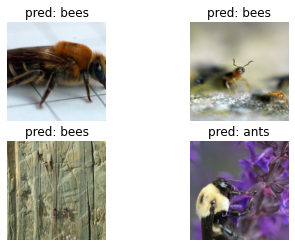

In [40]:
visualize_predictions(alexnet)

# VGG13 

## load class indices

In [41]:
import ast # Abstract Syntax Trees. 
with open('./imagenet1000_clsidx_to_labels.txt') as f:
    classes_data = f.read()
classes = ast.literal_eval(classes_data) # evaluate string as pythons' type. redefine classes
print({k: classes[k] for k in list(classes)[:5]})

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark'}


## load a model

In [45]:
vgg13 = torchvision.models.vgg13(pretrained=True)

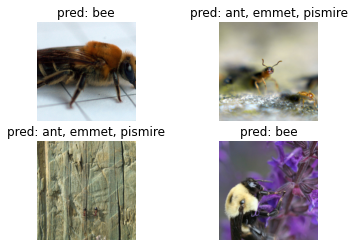

In [46]:
visualize_predictions(vgg13,4)